<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/video_notebooks/09_SkimLit_nlp_milestone_project_2_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

📖 **Resource:** If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm access to a GPU 

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-db391c52-2677-e2e6-6a8f-1efa97e89026)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct 

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 30, done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (30/30), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize 

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [8]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
   ...]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [10]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [11]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 442 ms, sys: 86.5 ms, total: 529 ms
Wall time: 532 ms


In [12]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is the format of a list of dictionaries, how about we trun it into a DataFrame to further visualize it?

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

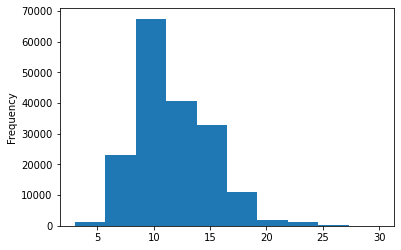

In [15]:
# Let's check the length of different lines
train_df.total_lines.plot.hist(); 

### Get lists of sentences

In [16]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [18]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [19]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a baseline

A baseline model is an important first step in any series of modelling experiments.

It sets the pace for the subsequent experiments.

It should start with a simple model and later models (with increasing complexity) will try to beat it.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [22]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [23]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from our helper function script: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

--2021-04-22 04:49:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-04-22 04:49:19 (116 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import calculate_results

In [26]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [29]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

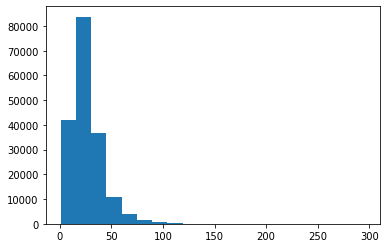

In [30]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [31]:
# How long of a setnence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [33]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [34]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
low-dose cta with mbir enables up to @ % dose reduction as compared with cta performed with asir while maintaining diagnostic adequacy for cta surveillance of patients who have undergone evar of a thoracic or abdominal aortic aneurysm .

Length of text: 39

Vectorized text: [[ 1127  3605     7 16941  7536   303     6   131   169    25    34     7
   3605   153     7  7586   258  2278   712  6716    11  3605  2815     4
     12    67    99  3273  5844     4     8  2090    16   743  1085  4049
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [37]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding

In [39]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically differnt numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space),
                               name="token_embedding")

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 low-dose cta with mbir enables up to @ % dose reduction as compared with cta performed with asir while maintaining diagnostic adequacy for cta surveillance of patients who have undergone evar of a thoracic or abdominal aortic aneurysm .

Sentence after vectorization (before embedding):
 [[ 1127  3605     7 16941  7536   303     6   131   169    25    34     7
   3605   153     7  7586   258  2278   712  6716    11  3605  2815     4
     12    67    99  3273  5844     4     8  2090    16   743  1085  4049
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[-0.04802219 -0.01015962  0.00490223 ... -0.03261849  0.00812943
    0.03043203]
  [-0.02444483 -0.03071042  0.01460406 ... -0.00753552 -0.00617326
    0.00294236]
  [ 0.04589846  0.03967238  0.00963162 ...  0.00912216  0.03048303
   -0.01298115]
  ...
  [-0.00760671 -0.01285071 -0.03756499 ... -0.02980448 

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [41]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [42]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [43]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [44]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [45]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [46]:
len(train_dataset)

5627

In [47]:
5627*32

180064

In [48]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 77s 80ms/step - loss: 1.1628 - accuracy: 0.5238 - val_loss: 0.6815 - val_accuracy: 0.7420
Epoch 2/3
562/562 [==============================] - 44s 79ms/step - loss: 0.6757 - accuracy: 0.7456 - val_loss: 0.6284 - val_accuracy: 0.7713
Epoch 3/3
562/562 [==============================] - 44s 79ms/step - loss: 0.6205 - accuracy: 0.7710 - val_loss: 0.5961 - val_accuracy: 0.7859


In [49]:
# Evalaute on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5975 - accuracy: 0.7861


[0.5975042581558228, 0.7860783934593201]

In [50]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.1910395e-01, 1.8863903e-01, 9.1777198e-02, 2.6551035e-01,
         3.4969445e-02],
        [4.5355678e-01, 2.8629509e-01, 1.4822427e-02, 2.3661332e-01,
         8.7124174e-03],
        [1.6295701e-01, 6.5065208e-03, 2.2286533e-03, 8.2823873e-01,
         6.9114736e-05],
        ...,
        [6.2707500e-06, 5.8430753e-04, 9.4748056e-04, 5.1592651e-06,
         9.9845684e-01],
        [5.8549751e-02, 4.8329592e-01, 9.3605481e-02, 6.5658920e-02,
         2.9888996e-01],
        [1.6351694e-01, 6.8997830e-01, 6.0407817e-02, 3.7280351e-02,
         4.8816562e-02]], dtype=float32), (30212, 5))

In [51]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [52]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60783794518734,
 'f1': 0.783433907135443,
 'precision': 0.7829343676825903,
 'recall': 0.7860783794518734}

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [53]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [54]:
# Test out the pretrained embedding on a random sentence 
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 the exposure-adjusted ae incidence regardless of causality was similar in periods @ ( @ ) and @ ( @ ) .
Setence after embedding:
[ 0.01977038  0.02243362  0.0479229  -0.0386384   0.05246279 -0.05058708
 -0.02161773 -0.03075982  0.06465533  0.07680867  0.0704236  -0.04631586
  0.04571636  0.03492888  0.05794131 -0.06503989 -0.0604578   0.00412879
  0.07964838 -0.03614014  0.01125568  0.05893939 -0.01718411  0.04884404
  0.00084615 -0.0066583  -0.01109742  0.0400309   0.00751991  0.06848188]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [55]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [57]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [58]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 12ms/step - loss: 1.0974 - accuracy: 0.5731 - val_loss: 0.7966 - val_accuracy: 0.6915
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7693 - accuracy: 0.7033 - val_loss: 0.7525 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7518 - accuracy: 0.7152 - val_loss: 0.7356 - val_accuracy: 0.7138


In [59]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.7379 - accuracy: 0.7155


[0.7378965616226196, 0.715510368347168]

In [60]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.4057617e-01, 3.3733779e-01, 1.6672050e-03, 2.1242118e-01,
        7.9976171e-03],
       [3.4118232e-01, 4.9462339e-01, 2.5410841e-03, 1.5916388e-01,
        2.4893212e-03],
       [2.3585790e-01, 1.2996121e-01, 1.3848483e-02, 5.8221167e-01,
        3.8120773e-02],
       ...,
       [1.6008025e-03, 4.8917751e-03, 5.1954009e-02, 7.6064188e-04,
        9.4079280e-01],
       [4.7978386e-03, 5.5189408e-02, 2.0356768e-01, 1.6417035e-03,
        7.3480338e-01],
       [1.9263166e-01, 2.7971533e-01, 4.7551993e-01, 7.0067351e-03,
        4.5126289e-02]], dtype=float32)

In [61]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [62]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 71.55103932212366,
 'f1': 0.7125920229163828,
 'precision': 0.7158553226406966,
 'recall': 0.7155103932212366}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings. 

### Creating a character-level tokenizer

In [63]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [64]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't h e   e x p o s u r e - a d j u s t e d   a e   i n c i d e n c e   r e g a r d l e s s   o f   c a u s a l i t y   w a s   s i m i l a r   i n   p e r i o d s   @   (   @   )   a n d   @   (   @   )   .'

In [65]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [66]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

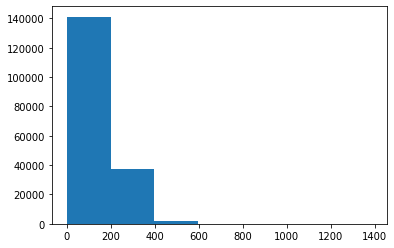

In [67]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [68]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [69]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standardization to "None" if you want to leave punctuation in
                                    name="char_vectorizer")

In [71]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [72]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [73]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 r e l a x a t i o n   t e c h n i q u e s   m i g h t   b e   e f f e c t i v e   i n   r e d u c i n g   s t r e s s   d u r i n g   t h a t   p e r i o d   .

Length of random_train_chars: 69

Vectorized chars:
 [[ 8  2 12  5 24  5  3  4  7  6  3  2 11 13  6  4 26 16  2  9 15  4 18 13
   3 22  2  2 17 17  2 11  3  4 21  2  4  6  8  2 10 16 11  4  6 18  9  3
   8  2  9  9 10 16  8  4  6 18  3 13  5  3 14  2  8  4  7 10  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 

### Creating a character-level embedding

In [74]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name="char_embed")

In [75]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 r e l a x a t i o n   t e c h n i q u e s   m i g h t   b e   e f f e c t i v e   i n   r e d u c i n g   s t r e s s   d u r i n g   t h a t   p e r i o d   .

Embedded chars (after vectorization and embedding):
 [[[ 0.03682853 -0.02176062 -0.0291571  ... -0.0383841   0.01376687
    0.01630721]
  [ 0.03733483 -0.02685341  0.00901743 ...  0.03550402  0.02244205
   -0.02421197]
  [-0.03578427 -0.0257957  -0.02139012 ...  0.01126925 -0.02738165
    0.03825811]
  ...
  [-0.03297446 -0.00501059 -0.04272097 ... -0.02842923  0.02169894
   -0.04187739]
  [-0.03297446 -0.00501059 -0.04272097 ... -0.02842923  0.02169894
   -0.04187739]
  [-0.03297446 -0.00501059 -0.04272097 ... -0.02842923  0.02169894
   -0.04187739]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [76]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [77]:
# Summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________

In [78]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [79]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 7ms/step - loss: 1.3998 - accuracy: 0.4312 - val_loss: 1.0372 - val_accuracy: 0.5934
Epoch 2/3
562/562 [==============================] - 4s 6ms/step - loss: 1.0268 - accuracy: 0.5927 - val_loss: 0.9303 - val_accuracy: 0.6396
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9322 - accuracy: 0.6372 - val_loss: 0.8674 - val_accuracy: 0.6609


In [80]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.16433214, 0.38347867, 0.05417649, 0.38544863, 0.01256402],
       [0.1726565 , 0.19425228, 0.00274712, 0.62493753, 0.00540649],
       [0.1269376 , 0.20097108, 0.05024505, 0.58828765, 0.03355869],
       ...,
       [0.02293018, 0.06129179, 0.18166408, 0.09462415, 0.63948977],
       [0.04491011, 0.24892128, 0.16164595, 0.04387634, 0.5006463 ],
       [0.49364576, 0.3557844 , 0.08555725, 0.04342405, 0.02158854]],
      dtype=float32)

In [81]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 3, 3, ..., 4, 4, 0])>

In [82]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 66.02674433999735,
 'f1': 0.6509344858149794,
 'precision': 0.658014497112375,
 'recall': 0.6602674433999736}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`) 
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [83]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [84]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

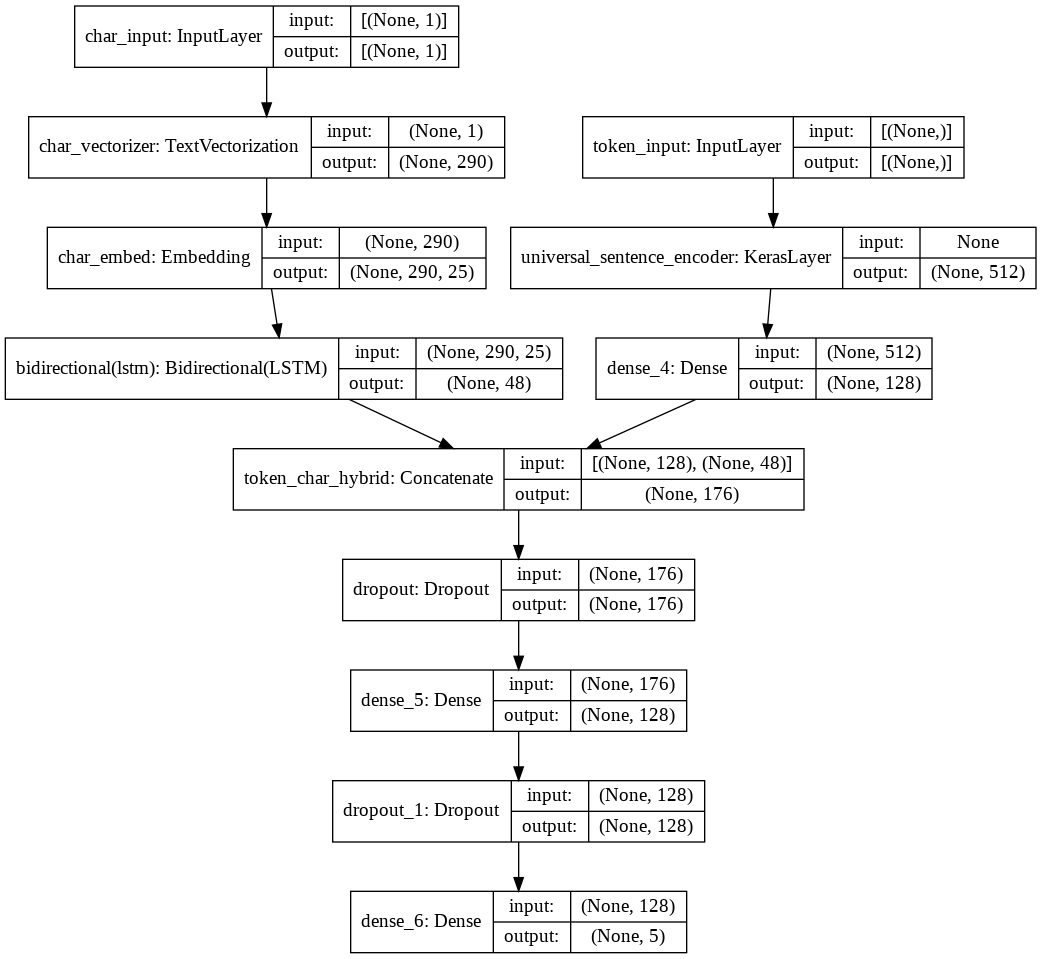

In [85]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [86]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want to try this
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [87]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [88]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [89]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

### Fitting a model on token and character-level sequences

In [90]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 48ms/step - loss: 1.1754 - accuracy: 0.5121 - val_loss: 0.7921 - val_accuracy: 0.6958
Epoch 2/3
562/562 [==============================] - 25s 44ms/step - loss: 0.8122 - accuracy: 0.6830 - val_loss: 0.7201 - val_accuracy: 0.7271
Epoch 3/3
562/562 [==============================] - 23s 40ms/step - loss: 0.7778 - accuracy: 0.7025 - val_loss: 0.7018 - val_accuracy: 0.7337


In [91]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.7031 - accuracy: 0.7315


[0.7030972838401794, 0.7315305471420288]

In [92]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.2659917e-01, 2.9139048e-01, 4.0054899e-03, 2.7395955e-01,
        4.0453025e-03],
       [3.1601429e-01, 4.1725042e-01, 1.9901453e-03, 2.6367852e-01,
        1.0666000e-03],
       [3.0143514e-01, 1.1346084e-01, 4.0722989e-02, 5.1282227e-01,
        3.1558726e-02],
       ...,
       [8.0299139e-04, 1.0325610e-02, 4.8297979e-02, 3.3294794e-04,
        9.4024044e-01],
       [7.2415895e-03, 7.0295162e-02, 1.5365131e-01, 2.8205705e-03,
        7.6599145e-01],
       [3.8415033e-01, 3.7360224e-01, 1.8221650e-01, 2.2180034e-02,
        3.7850838e-02]], dtype=float32)

In [93]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [94]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.15305176750961,
 'f1': 0.7292546002244985,
 'precision': 0.7334872389494929,
 'recall': 0.731530517675096}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [95]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑 **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [96]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

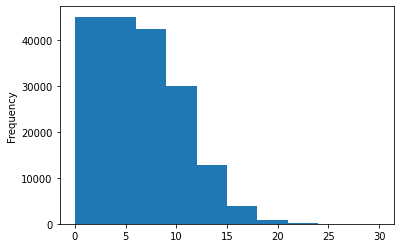

In [97]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [98]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [99]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

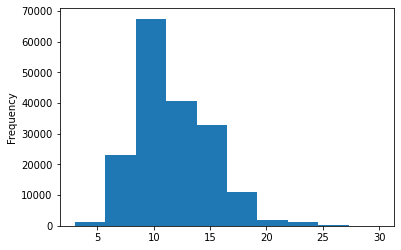

In [100]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [101]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [102]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities 
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [103]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
# inputs, shape = ?
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
# dense layer with 32 units & relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [104]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________

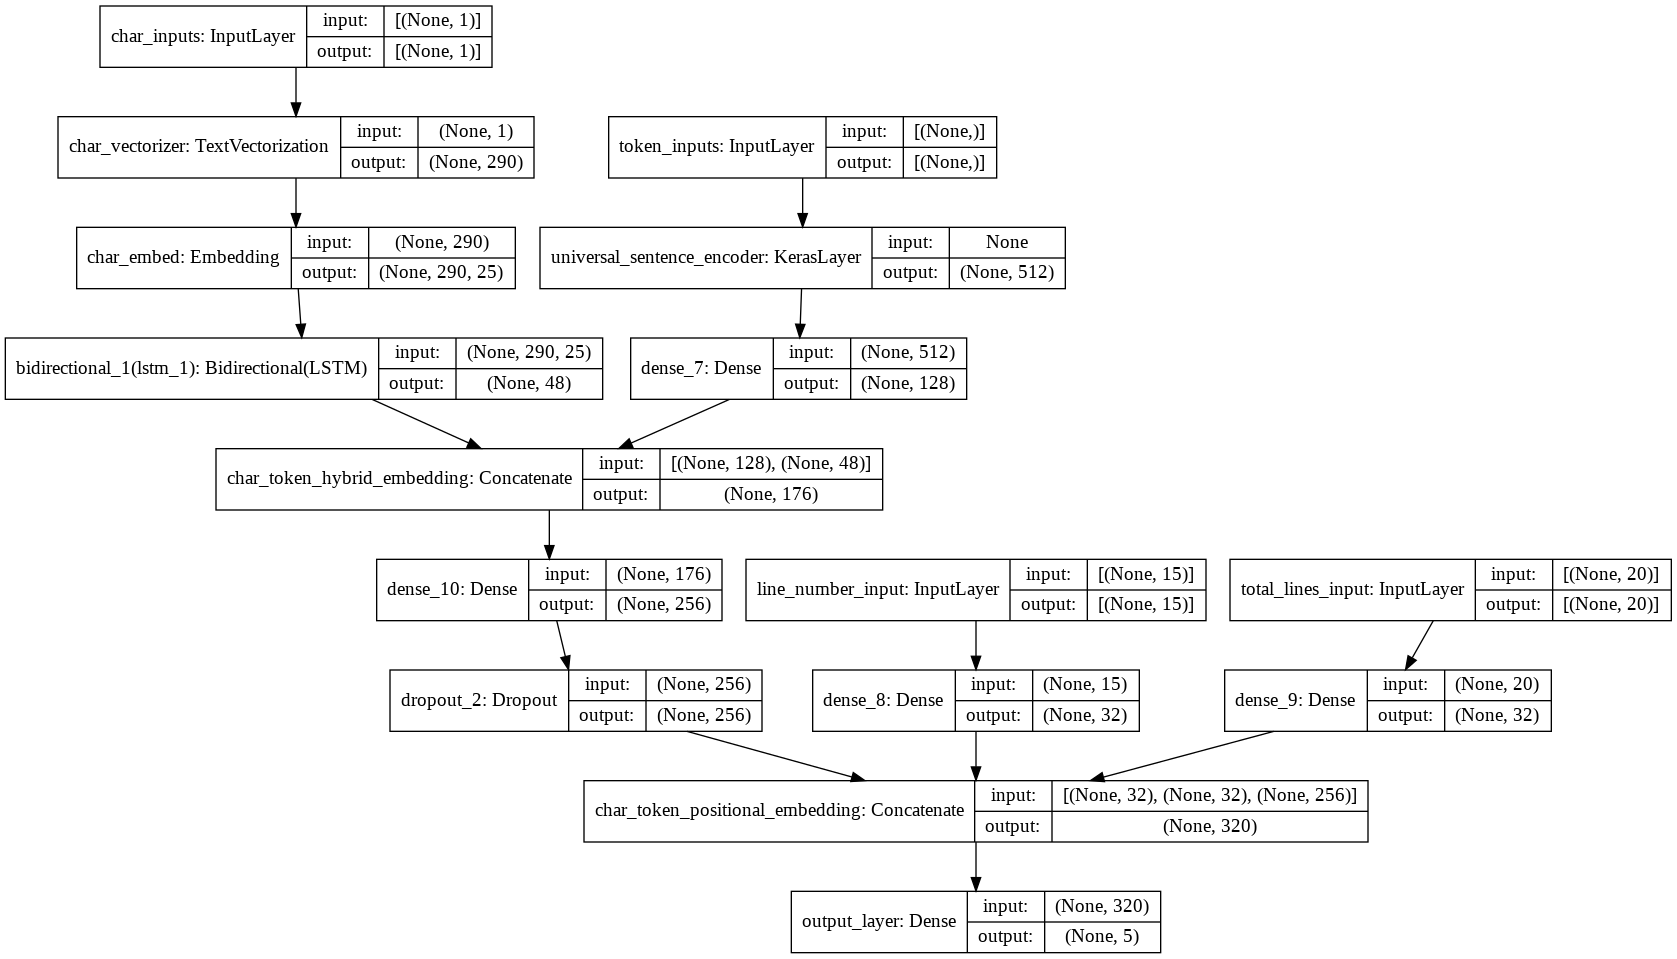

In [105]:
# Plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]` 

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]` 

> 📖 **Resource:** For more on label smoothing, see this blog post from PyImageSearch: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/ 

In [106]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data

In [107]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [108]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

### Fitting, evaluating and making predicitions with our tribrid model

In [109]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 48ms/step - loss: 1.2179 - accuracy: 0.6248 - val_loss: 0.9806 - val_accuracy: 0.8045
Epoch 2/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9705 - accuracy: 0.8126 - val_loss: 0.9497 - val_accuracy: 0.8271
Epoch 3/3
562/562 [==============================] - 23s 40ms/step - loss: 0.9543 - accuracy: 0.8176 - val_loss: 0.9395 - val_accuracy: 0.8305


In [110]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 21s 20ms/step


array([[0.5018536 , 0.11003216, 0.01080302, 0.3623029 , 0.01500831],
       [0.5277809 , 0.09389856, 0.03740778, 0.32971728, 0.01119554],
       [0.28180408, 0.08831163, 0.11122281, 0.4640036 , 0.05465783],
       ...,
       [0.03720175, 0.10561775, 0.04516607, 0.02880904, 0.78320545],
       [0.03478291, 0.32260662, 0.09570655, 0.02872073, 0.51818323],
       [0.2580621 , 0.5275318 , 0.11692096, 0.04311179, 0.05437337]],
      dtype=float32)

In [111]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [112]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.36422613531047,
 'f1': 0.832856749242421,
 'precision': 0.8329936901758904,
 'recall': 0.8336422613531047}

## Compare model results

In [113]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.607838,0.782934,0.786078,0.783434
model_2_pretrained_token_embedding,71.551039,0.715855,0.715510,0.712592
model_3_custom_char_embedding,66.026744,0.658014,0.660267,0.650934
model_4_hybrid_char_token_embedding,73.153052,0.733487,0.731531,0.729255
model_5_pos_char_token_embedding,83.364226,0.832994,0.833642,0.832857


In [114]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

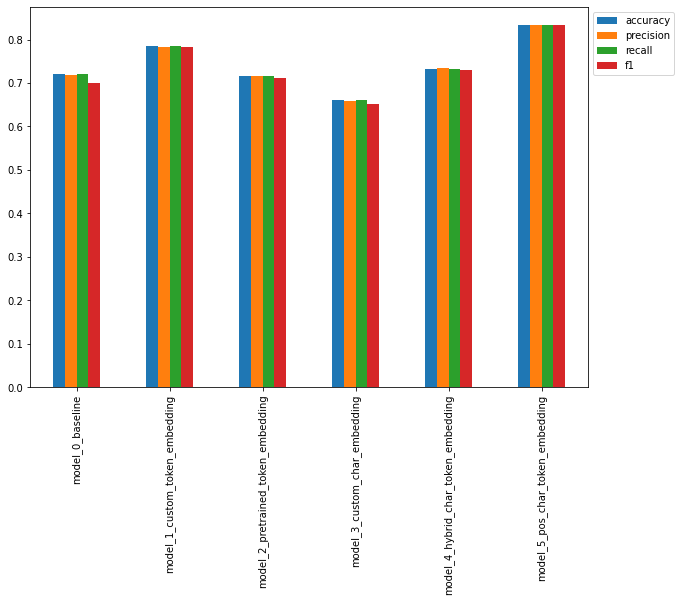

In [115]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

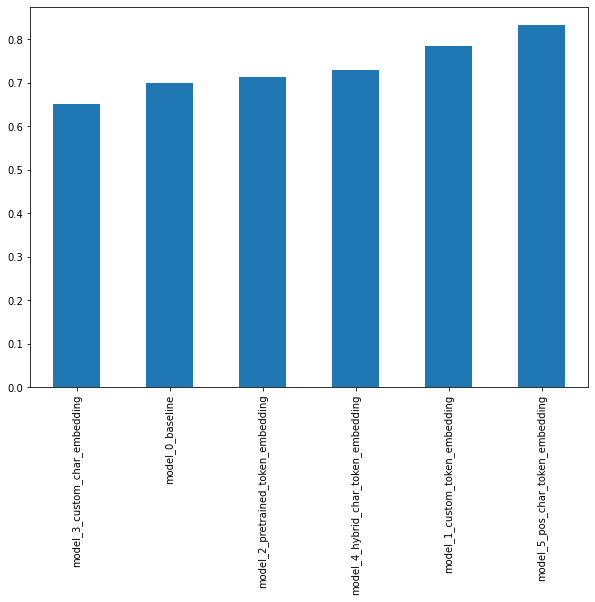

In [116]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and load model 

In [117]:
# Save the best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [118]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [120]:
# Make predictions with the loaded moel on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [122]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.36422613531047,
 'f1': 0.832856749242421,
 'precision': 0.8329936901758904,
 'recall': 0.8336422613531047}

In [125]:
assert model_5_results == loaded_model_results

In [126]:
# Check the loaded model summary
loaded_model.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________

## Download and load in a pretrained model from Google Storage

In [134]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [135]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2021-04-22 05:16:26--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.176, 172.217.12.240, 172.217.15.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962957902 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 918.35M   257MB/s    in 3.6s    

2021-04-22 05:16:30 (258 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962957902/962957902]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  

In [136]:
# Load in downloaded Google Storage model
loaded_gs_model = tf.keras.models.load_model("skimlit_gs_model/skimlit_tribrid_model/")

In [137]:
# Evalaute the loaded Google Storage model
loaded_gs_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 23s 22ms/step - loss: 0.9459 - accuracy: 0.8283


[0.9459028244018555, 0.8283132314682007]

## Your challenges

Try these out before moving onto the next module.

The GitHub has an example of how to do each but I'd encourage you to try it for yourself first (you've got this!).

1. Turn the test data samples into a tf.data Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test samples.
2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).
3. Make example predictions (on RCT abstracts from the wild), you can go to PubMed to find these: https://pubmed.ncbi.nlm.nih.gov/, find and use our model to predict on 3-4 different abstracts from the wild.
  * Some examples: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json 
4. See the exercises and extra curriculum section on GitHub to further test your skills (for section 09) 

> See the full course materials (including an example of how to do the above) on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning